### Clasificación de imágenes de personas con mascarilla 

#### Carga de Librerías

In [60]:
from keras.utils import image_dataset_from_directory

#Reescalar
from keras.layers import (
    Rescaling, 
    RandomFlip, 
    RandomRotation,
    RandomZoom, 
    RandomTranslation
)

from keras.models import Sequential  #Falta esta importación

# 4.2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)

from tensorflow.keras import layers


# 4.4
import numpy as np
from tensorflow.keras.preprocessing import image

#### Carga de los datos

In [61]:
#hay que separar el conjunto de datos (no lo estaba haciendo)
#ponemos por defecto la imagen en 128x128
#IMG_SIZE = 128x128
#también se puede hacer con el batch (como aquí)
BATCH_SIZE = 32 #quiere decir que tomará 32 imágenes por lote para entrenar o validar

train_dataset = keras.utils.image_dataset_from_directory(
    '.\\train',
    validation_split=0.2,  #Reserva 20% para validación
    subset="training",
    seed=123,
    image_size=(128, 128),
    #image_size=IMG_SIZE se puede hacer así, con una variable
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='binary'
)

val_dataset = keras.utils.image_dataset_from_directory(
    '.\\train',
    validation_split=0.2, #20 % para validación
    subset="validation",
    seed=123,
    image_size=(128, 128), #tamaño de la imagen
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='binary'
)

test_dataset = keras.utils.image_dataset_from_directory(
    '.\\test',
    image_size=(128, 128),
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='binary'
)


Found 656 files belonging to 2 classes.
Using 525 files for training.
Found 656 files belonging to 2 classes.
Using 131 files for validation.
Found 160 files belonging to 2 classes.


### NORMALIZACIÓN DE IMÁGENES

Ahora es importante normalizar los valores de la imagen a una escala de 0 a 1

Podemos usar **Rescaling** y por otro lado para prevenir el overfitting usaremos el **data augmentation**

In [62]:
#1 funcion preprocess con ORDEN 1- aumentacion y 2- normalizacion (mejor organizado)
#2 reescalado de la normalizacion

data_augmentation = Sequential([
 RandomFlip("horizontal"), #Volteo horizontal
 RandomRotation(0.2), #Rotaciones 20% de 360º
 RandomZoom(0.1), #Zoom hasta 10%
 RandomTranslation(0.1, 0.1) #Desplaz. vertical y horizontal
])


normalization_layer = layers.Rescaling(1./255)


def preprocess(image, label):
    image = data_augmentation(image) #Aplicamos aumentación primero
    image = normalization_layer(image) #Aplicamos normalización segundo
    return image, label

#aplicamos el preprocess(aumentacion,normalizacion) en el train
train_dataset = train_dataset.map(preprocess)
#normalizamos validacion y test
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))



#### 4.2 Construcción y compilación de la CNN básica con Keras

Además de las capas conocidas **Input** y **Dense** añadiremos estas nuevas:

- Conv2D -> Convolucional
- MaxPooling2D -> Para realizar pooling (reducciond de dimensionalidad)
- Flatten -> Aplanado antes de Dense

In [ ]:
model = keras.Sequential([
 Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), #cambiado a 3
 MaxPooling2D((2, 2)),
 Conv2D(64, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),
 Dropout(0.25),
 Flatten(),
 Dense(64, activation='relu'),
 Dense(1, activation='sigmoid') #lo cambiamos de 10 a 2 porque es binario (mascarilla o no mascarilla)
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\juan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

El modelo consta de dos capas convolucionales con ReLu como función de activación, seguidas de capas de pooling y una capa completamente conectada (la clásica capa oculta de neuronas vista en la unidad anterior) para la clasificación

#### 4.3 Entrenamiento, evaluación y visualización de resultados

Una vez hecha la CNN deberemos entrenarla

In [64]:
history = model.fit(
 train_dataset,
 validation_data=val_dataset,
 epochs=20,
 #batch_size=32 ya lo ponemos antes
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.5600 - loss: 1.2011 - val_accuracy: 0.6947 - val_loss: 0.6621
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6683 - loss: 0.6215 - val_accuracy: 0.8702 - val_loss: 0.4182
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.8104 - loss: 0.4597 - val_accuracy: 0.8931 - val_loss: 0.3136
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.8872 - loss: 0.2930 - val_accuracy: 0.9313 - val_loss: 0.1957
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9131 - loss: 0.2268 - val_accuracy: 0.9160 - val_loss: 0.2249
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9087 - loss: 0.2311 - val_accuracy: 0.9466 - val_loss: 0.1480
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9353 - loss: 0.1845 - val_accuracy: 0.9466 - val_loss: 0.1327
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9695 - loss: 0.1024 - val_accuracy: 0.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9346 - loss: 0.1649
Pérdida en test: 0.1479
Precisión en test: 0.9250


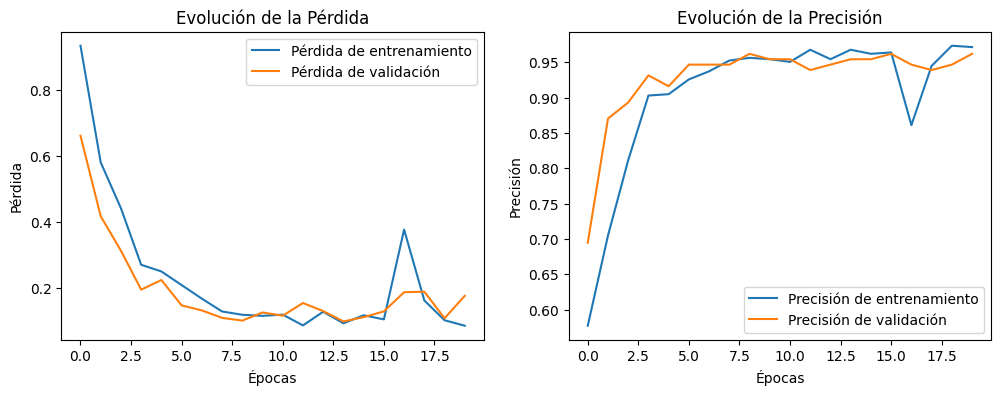

In [65]:
#Evaluación del modelo en el conjunto de test
loss, accuracy = model.evaluate(test_dataset)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")
#Visualización de la evolución del entrenamiento
import matplotlib.pyplot as plt

epochs = len(history.history['loss'])  #Faltaba (obtenemos el número real de épocas entrenadas)

#Extraer los valores del historial
epochs_range = range(epochs)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')
plt.show()

In [66]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nPrecisión en test: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9325 - loss: 0.1334

Precisión en test: 0.9250


Como vemos los resultados son buenos

#### 4.4 Uso del modelo en predicciones

Una vez ha sido entrenado el modelo podemos utilizarlo para hacer predicciones con nuevas imágenes

Tenemos que cargar la imagen, procesarla igual que las imágenes del entrenamiento y pasarla al modelo

In [67]:
#Cargar la imagen y preprocesarla
#Alternamos entre fotoconmascarilla.jpeg y fotosinmascarilla.jpeg para probar el modelo
img = image.load_img("fotosinmascarilla.jpeg", target_size=(128, 128)) #224 estaba por defecto
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) #Añadir a batch
img_array /= 255.0 #Normalización

#Realizar la predicción
prediccion = model.predict(img_array)
#clase_predicha = np.argmax(prediccion) #para multiclase
clase_predicha = (prediccion > 0.5).astype(int)  #1 = Con mascarilla, 0 = Sin mascarilla
print(f"La imagen pertenece a la clase: {clase_predicha}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
La imagen pertenece a la clase: [[1]]


0 = Cono mascarilla

1 = Sin mascarilla

Como vemos, con las dos imágenes que hemos cogido de prueba, predice bien!!!!

In [73]:
from sklearn.metrics import classification_report

# Obtener etiquetas reales y predicciones del modelo
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = (predictions > 0.5).astype(int)

    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Generar el reporte de clasificación
report = classification_report(true_labels, pred_labels, target_names=["Sin mascarilla", "Con mascarilla"])
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
                precision    recall  f1-score   support

Sin mascarilla       1.00      0.85      0.92        80
Con mascarilla       0.87      1.00      0.93        80

      accuracy                           0.93       160
     macro avg       0.93      0.93      0.92       160
  weighted avg       0.93      0.93      0.92       160



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


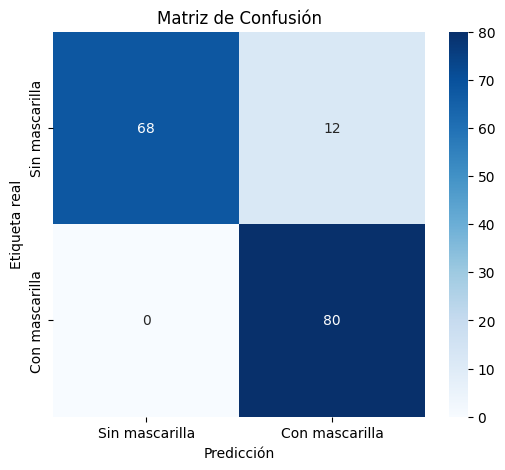

In [69]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener etiquetas reales y predicciones del modelo
true_labels = []
pred_labels = []

for images, labels in test_dataset:  # test_dataset ya contiene imágenes y etiquetas reales
    predictions = model.predict(images)  # Obtener predicciones
    predicted_classes = (predictions > 0.5).astype(int) # Obtener la clase con mayor probabilidad

    true_labels.extend(labels.numpy())  # Guardar etiquetas reales
    pred_labels.extend(predicted_classes)  # Guardar predicciones

# Generar la matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sin mascarilla", "Con mascarilla"],
            yticklabels=["Sin mascarilla", "Con mascarilla"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()


In [71]:
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype("int32")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


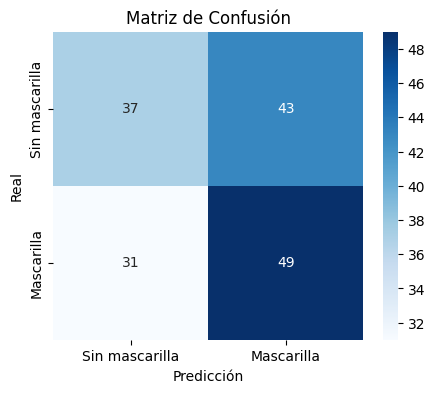

In [72]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sin mascarilla", "Mascarilla"], yticklabels=["Sin mascarilla", "Mascarilla"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [74]:
print(classification_report(y_true, y_pred, target_names=["No Mascarilla", "Mascarilla"]))

               precision    recall  f1-score   support

No Mascarilla       0.54      0.46      0.50        80
   Mascarilla       0.53      0.61      0.57        80

     accuracy                           0.54       160
    macro avg       0.54      0.54      0.53       160
 weighted avg       0.54      0.54      0.53       160

